<a href="https://colab.research.google.com/github/dcastf01/object_detection_TFM/blob/main/Data_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to study the datasets

In [1]:
#@title Tarjeta ofrecida por nvidia
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
#@title Descargar repositorios e instalar librerias
# %%capture

import time
import pathlib

import os
import pandas as pd
import tqdm


start_time = time.time()
!git clone https://github.com/dcastf01/colab_utils.git
!git clone https://github.com/dcastf01/object_detection_TFM.git
!pip install git+https://github.com/tensorflow/examples.git
!pip install tensorflow-addons
!pip install -U tfds-nightly
!pip install pydub
!pip install opencv-python-headless==4.2.0.34
!pip install tf_slim
!pip install pycocotools
# Clone the tensorflow models repository if it doesn't already exist

##Descargar y crear dataframe

##Compcars

In [3]:
from object_detection_TFM.dataset.compcars import compcar_analisis

In [ ]:
path_txt="/content/object_detection_TFM/dataset/compcars/id_drive_to_download.txt"
images_path="/content/data/image"
label_path="/content/data/label"
filename_csv_with_data="/content/object_detection_TFM/dataset/compcars/all_information_compcars.csv"

In [ ]:
%%time
from colab_utils.utils.download_files import download_file_from_google_drive,generate_id_destination_to_download
for id, destination in generate_id_destination_to_download(path_txt).items():
  download_file_from_google_drive(id,destination)
!bash /content/object_detection_TFM/dataset/compcars/unzip_remove_files.sh

In [ ]:
%%time
df=compcar_analisis.get_df_from_files(images_path,label_path)

In [ ]:
#@title Exportar dataframe
df.to_csv(filename_csv_with_data)

In [ ]:
#@title Cargar dataframe from csv
from object_detection_TFM.dataset.compcars.analisis_dataset import  set_type_data_compcars
df=pd.read_csv(filename_csv_with_data,index_col =[0])
df=set_type_data_compcars(df)
df["extra"]=df["model_id"].astype(str)+df["released_year"].astype(str)

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
def create_pareto_diagram( df,category):
  data=df[category].value_counts()
 
  df = pd.DataFrame({category: data})
  # df.index = data.index
  df = df.sort_values(by=[category],ascending=False)
  
  df["cumpercentage"] = df[category].cumsum()/df[category].sum()*100

  fig, ax = plt.subplots(figsize=(10,7))
  bar=df.plot(kind='bar',y=category,ax=ax)
  # ax.bar(df.index, df[category], color="C0")
  
  ax2 = ax.twinx()
  line1=df.plot(kind='line',y="cumpercentage",ax=ax2,color="C1", marker="D", ms=7)
  # ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
  ax2.yaxis.set_major_formatter(PercentFormatter())
  print(df)
  ax.tick_params(axis="y", colors="C0")
  ax2.tick_params(axis="y", colors="C1")
  ax2.set_ylim(ymin=0)
  ax.legend(loc="right")
  # ax2.legend(loc="right", handlelength=1, handleheight=1.125)
  # plt.legend(loc="right")

  plt.show()

In [ ]:
create_pareto_diagram(df,"viewpoint")

Debido a que la categoría 4 ( frontales algo ladeadas) y la categoría 1 (frontales) suman más que la 5 y la dos optaremos por utilizar imágenes frontales.

In [ ]:
create_pareto_diagram(df,"make_id")

Se observa el desbalanceo que existe de imagenes respecto al año de fabricación, por lo que para normalizar los datos se optará a quitar está variable

In [ ]:
create_pareto_diagram(df,"model_id")

Se observa cierto desbalanceo de imágenes por lo que habrá que aplicar en el entrenamiento alguna técnica para equilibrar los pesos de la red

In [ ]:
create_pareto_diagram(df,"released_year")

Se observa el desbalanceo que existe de imagenes respecto al año de fabricación, por lo que para normalizar los datos se optará a quitar está variable

##cars196

In [4]:
from object_detection_TFM.dataset.cars196 import cars196
import tensorflow_datasets as tfds

path_images= "/content/images/" #@param {type:"string"}

cars196.Cars196()
cars_builder=tfds.builder("cars196")
cars_builder.download_and_prepare(download_dir=path_images)

Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.0.0. Subsequent calls will reuse this data.


Solo se analizarán las imágenes de entrenamiento debido a que de las imágenes de Test no se han encontrado las etiquetas y se desea hacer una análisis rápido

In [60]:
data_annotations_path_train="/content/images/extracted/TAR_GZ.ai.stanford.edu_jkrause_cars_car_devkituX3rRjr31Ytr-qGLKk3pgp8PeejOZj36kmG_eBDprM0.tgz/devkit/cars_train_annos.mat"

import tensorflow as tf

# image_dict = returnImageDict(path_train)

# bbox_dict = returnBbox(data_annotations_path_train, image_dict)
'''
-cars_train_annos.mat:
  Contains the variable 'annotations', which is a struct array of length
  num_images and where each element has the fields:
    bbox_x1: Min x-value of the bounding box, in pixels
    bbox_x2: Max x-value of the bounding box, in pixels
    bbox_y1: Min y-value of the bounding box, in pixels
    bbox_y2: Max y-value of the bounding box, in pixels
    class: Integral id of the class the image belongs to.
    fname: Filename of the image within the folder of images.
'''
def create_dataframe_cars196(data_annotations):
  df=pd.DataFrame()


  with tf.io.gfile.GFile(data_annotations, 'rb') as f:
    mat = tfds.core.lazy_imports.scipy.io.loadmat(f)
    for example in mat['annotations'][0]:
      image_name = example[-1].item().split('.')[0]
      label = cars196._NAMES[example[4].item() - 1]

      features = {
            'label': label,
            'filename':str(image_name),
        }
      df=df.append(features,ignore_index=True)  
  return df
df=create_dataframe_cars196(data_annotations_path_train)
# df_test=create_dataframe_cars196(data_annotations_path_test) 


A través de label se generan las características make, model y released para hacer una similitud con el dataset anterior

In [62]:
df["make_id"]=df.label.str.split(" ").str[0]
df["model_id"]=df.label.str.split(" ").str[1:-1].str.join(" ")
df["released_year"]=df.label.str.split(" ").str[-1]
df

,filename,label,make_id,model_id,released_year
0,00001,Audi TTS Coupe 2012,Audi,TTS Coupe,2012
1,00002,Acura TL Sedan 2012,Acura,TL Sedan,2012
2,00003,Dodge Dakota Club Cab 2007,Dodge,Dakota Club Cab,2007
3,00004,Hyundai Sonata Hybrid Sedan 2012,Hyundai,Sonata Hybrid Sedan,2012
4,00005,Ford F-450 Super Duty Crew Cab 2012,Ford,F-450 Super Duty Crew Cab,2012
...,...,...,...,...,...
8139,08140,Chrysler Town and Country Minivan 2012,Chrysler,Town and Country Minivan,2012
8140,08141,smart fortwo Convertible 2012,smart,fortwo Convertible,2012
8141,08142,Mercedes-Benz SL-Class Coupe 2009,Mercedes-Benz,SL-Class Coupe,2009
8142,08143,Ford GT Coupe 2006,Ford,GT Coupe,2006


Destacar que no se tiene en ningún momento el viewpoint el cual es muy útil

               make_id  cumpercentage
Chevrolet          905      11.112475
Dodge              630      18.848232
Audi               589      26.080550
BMW                531      32.600688
Ford               521      38.998035
Hyundai            438      44.376228
Mercedes-Benz      261      47.581041
Chrysler           260      50.773576
Acura              242      53.745088
Bentley            238      56.667485
GMC                238      59.589882
Jeep               220      62.291257
Nissan             171      64.390963
Toyota             168      66.453831
Suzuki             167      68.504420
Ferrari            164      70.518173
Honda              161      72.495088
Lamborghini        161      74.472004
Buick              158      76.412083
Aston              157      78.339882
Volkswagen         132      79.960707
Volvo              131      81.569253
Cadillac           129      83.153242
Rolls-Royce        114      84.553045
Spyker              88      85.633595
Land        

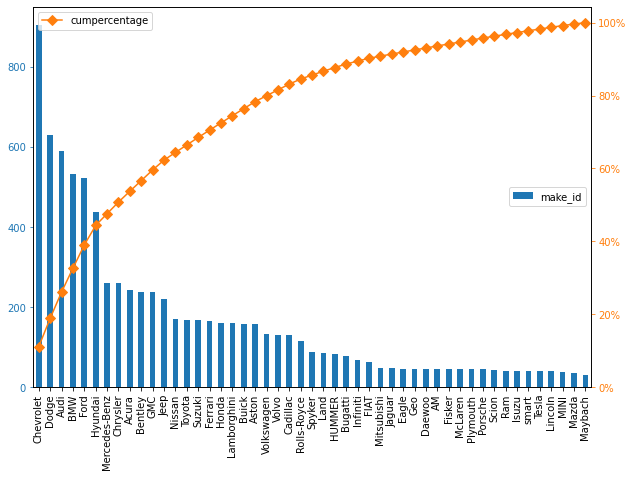

In [64]:
create_pareto_diagram(df,"make_id")

                                    model_id  cumpercentage
Durango SUV                               90       1.105108
Golf Hatchback                            89       2.197937
F-150 Regular Cab                         88       3.278487
S4 Sedan                                  85       4.322200
Odyssey Minivan                           83       5.341356
...                                      ...            ...
Phantom Drophead Coupe Convertible        31      98.637033
Express Cargo Van                         30      99.005403
Landaulet Convertible                     29      99.361493
500 Abarth                                28      99.705305
Accent Sedan                              24     100.000000

[189 rows x 2 columns]


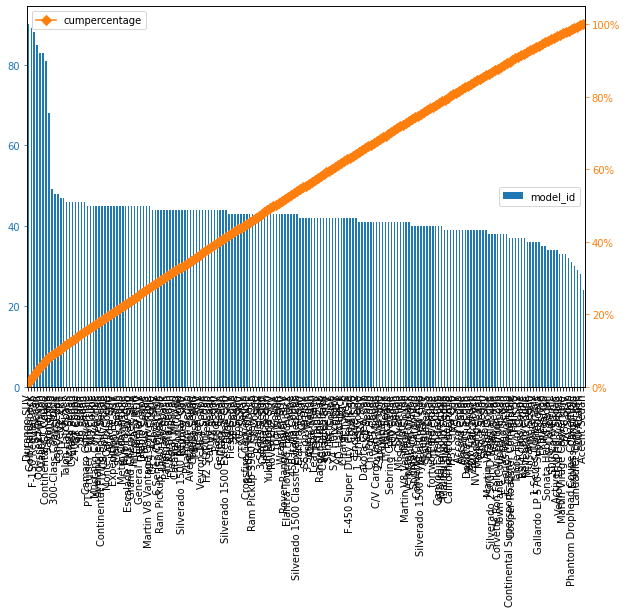

In [65]:
create_pareto_diagram(df,"model_id")

      released_year  cumpercentage
2012           4818      59.160118
2007           1059      72.163556
2009            540      78.794204
2010            413      83.865422
2011            312      87.696464
2008            283      91.171415
1993            139      92.878193
1994            128      94.449902
1998             92      95.579568
2001             90      96.684676
1991             46      97.249509
2006             46      97.814342
2000             45      98.366896
2002             45      98.919450
1999             44      99.459725
1997             44     100.000000


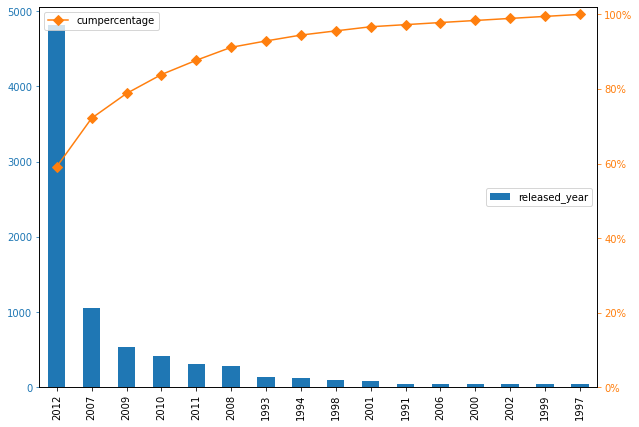

In [66]:
create_pareto_diagram(df,"released_year")

In [ ]:
data=df["viewpoint"].value_counts()

In [ ]:
data.sort_values()